In [1]:
%matplotlib inline

Initialize an Astropy Table to store model galaxies

In [2]:
from astropy.table import Table

galaxies = Table()

num_halos = int(1e6)
galaxies['galid'] = np.arange(num_halos).astype(int)

# Generate fake halos from a power law mass function

Using `scipy.stats.powerlaw`, we generate a Monte Carlo realization of a sample of host halo masses

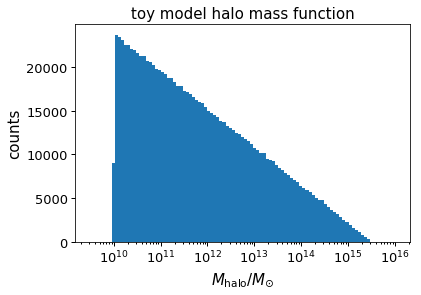

In [3]:
from scipy.stats import powerlaw

#  First generate a power law variable distributed across the unit interval
uran = np.random.rand(num_halos)
index = 2
y = powerlaw.isf(1-uran, index)

#  Now rescale the variable to span the typical range of host halo masses
log_mhalo_min, log_mhalo_max = 10, 15.5
dlog_mhalo = log_mhalo_max - log_mhalo_min
galaxies['host_halo_mass'] = 10**(log_mhalo_max - dlog_mhalo*y)

#  Inspect the results
fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')
log_mhalo_bins = np.logspace(9.5, 16, 100)
__=ax.hist(galaxies['host_halo_mass'], bins=log_mhalo_bins)
xlabel = ax.set_xlabel(r'$M_{\rm halo}/M_{\odot}$')
ylabel = ax.set_ylabel(r'counts')
title = ax.set_title('toy model halo mass function')

figname = 'power_law_mass_function.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

#  Toy model for the central galaxy $M_{\rm halo}-L$ relation

Use the Conditional Luminosity Function in Halotools to map halo mass to central galaxy luminosity according to Cacciato et al. (2009)

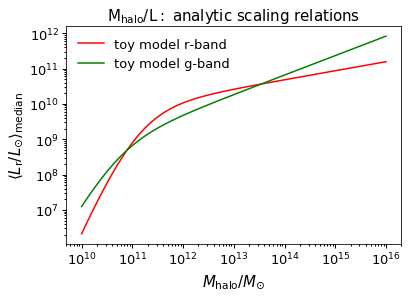

In [4]:
from halotools.empirical_models import Cacciato09Cens
clf_model = Cacciato09Cens()

halo_mass_table = np.logspace(10, 16, 100)

#  Set parameters for the r-band relation (these are just toy values)
clf_model.param_dict['gamma_1'] = 3.273
clf_model.param_dict['log_L_0'] = 9.935
clf_model.param_dict['log_M_1'] = 11.07
clf_model.param_dict['gamma_2'] = 0.255

median_lr_table = clf_model.median_prim_galprop(prim_haloprop=halo_mass_table)

#  Store the parameter dictionary for later use
from copy import deepcopy
rband_dict = deepcopy(clf_model.param_dict)

#  Set parameters for the g-band relation (these are just toy values)
clf_model.param_dict['gamma_1'] = 2.5
clf_model.param_dict['log_L_0'] = 9.
clf_model.param_dict['log_M_1'] = 10.7
clf_model.param_dict['gamma_2'] = 0.55

median_lg_table = clf_model.median_prim_galprop(prim_haloprop=halo_mass_table)

#  Store the parameter dictionary for later use
gband_dict = deepcopy(clf_model.param_dict)

#  Visually inspect the results
fig, ax = plt.subplots(1, 1)
__=ax.loglog()

__=ax.plot(halo_mass_table, median_lr_table, label='toy model r-band', color='red')
__=ax.plot(halo_mass_table, median_lg_table, label='toy model g-band', color='green')

xlabel = ax.set_xlabel(r'$M_{\rm halo}/M_{\odot}$')
ylabel = ax.set_ylabel(r'$\langle L_{\rm r} / L_{\odot}\rangle_{\rm median}$')
title = ax.set_title(r'${\rm M_{halo}/L}:$ analytic scaling relations')
legend = ax.legend()

figname = 'analytic_mass_to_light_g_r_bands.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

# Generate a Monte Carlo realization of the model

Using scipy, we generate correlated Gaussian randoms according to an input covariance matrix

In [5]:
#  Set up the (toy) covariance matrix
sqrt_cov = np.array(((0.05, 0.05), (0.05, 0.15)))
cov = sqrt_cov*sqrt_cov

#  Calculate the eigenvectors of Cov 
from scipy.linalg import eigh
evals, evecs = eigh(cov)

#  Define a transformation matrix U so that U*U^T = cov
U = np.dot(evecs, np.diag(np.sqrt(evals)))

#  Draw Gaussian randoms with mean=0 and std=1 for two independent variables: (a, b)
from scipy.stats import norm
a = norm.rvs(size=num_halos)
b = norm.rvs(size=num_halos)
X = np.array((a, b)).reshape((2, num_halos))

#  Use the transformation matrix U to calculate correlated variables (c, d)
Y = np.dot(U, X)
c, d = Y[0, :], Y[1, :]

#  Logarithmically add Gaussian noise to the desired medians

In [6]:
#  Compute the desired medians at each halo mass

#  Update the model dictionary and compute the median
clf_model.param_dict.update(gband_dict)
median_lg = clf_model.median_prim_galprop(prim_haloprop=galaxies['host_halo_mass'])

#  Update the model dictionary and compute the median
clf_model.param_dict.update(rband_dict)
median_lr = clf_model.median_prim_galprop(prim_haloprop=galaxies['host_halo_mass'])

#  Logarithmically add Gaussian noise
log_median_r_and_g = np.log10(np.array((median_lr, median_lg)).reshape((2, num_halos)))

log_mc_r_and_g = log_median_r_and_g + Y

galaxies['luminosity_rband'] = 10**log_mc_r_and_g[0, :]
galaxies['luminosity_gband'] = 10**log_mc_r_and_g[1, :]

# Plot the results

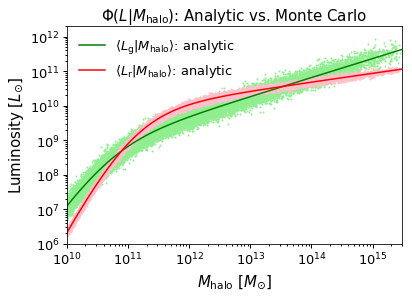

In [7]:
from scipy.stats import binned_statistic
logm_bins = np.linspace(10, 15.5, 50)
logm_mids = 0.5*(logm_bins[:-1] + logm_bins[1:])

median_rband, __, __ = binned_statistic(
        galaxies['host_halo_mass'], galaxies['luminosity_rband'], 
        bins=10**logm_bins, statistic='median')

median_gband, __, __ = binned_statistic(
    galaxies['host_halo_mass'], galaxies['luminosity_gband'], 
    bins=10**logm_bins, statistic='median')


fig, ax = plt.subplots(1, 1)
__=ax.loglog()

nskip=50
# __=ax.plot(10**logm_mids, median_gband, color='green', 
#           label=r'$\langle L_{\rm g} \vert M_{\rm halo} \rangle$: Monte Carlo')
# __=ax.plot(10**logm_mids, median_rband, color='red', 
#           label=r'$\langle L_{\rm r} \vert M_{\rm halo} \rangle$: Monte Carlo')

__=ax.scatter(galaxies['host_halo_mass'][::nskip], galaxies['luminosity_gband'][::nskip], 
              s=1, color='lightgreen', label='')
__=ax.scatter(galaxies['host_halo_mass'][::nskip], galaxies['luminosity_rband'][::nskip], 
              s=1, color='pink', label='')

__=ax.plot(halo_mass_table, median_lg_table,  color='green', 
          label=r'$\langle L_{\rm g} \vert M_{\rm halo} \rangle$: analytic')
__=ax.plot(halo_mass_table, median_lr_table, color='red', 
          label=r'$\langle L_{\rm r} \vert M_{\rm halo} \rangle$: analytic')

xlim = ax.set_xlim(1e10, 3e15)
ylim = ax.set_ylim(1e6, 2e12)

xlabel = ax.set_xlabel(r'$M_{\rm halo}$ $[M_{\odot}]$')
ylabel = ax.set_ylabel(r'Luminosity $[L_{\odot}]$')
title = ax.set_title(r'$\Phi(L\vert M_{\rm halo})$: Analytic vs. Monte Carlo')
legend = ax.legend()

figname = 'mass_to_light_scaling_analytic_vs_monte_carlo.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

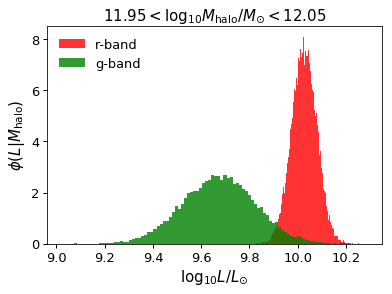

In [8]:
halo_mass_mask = (galaxies['host_halo_mass'] < 10**12.05) & (galaxies['host_halo_mass'] > 10**11.95)

fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(galaxies['luminosity_rband'][halo_mass_mask]), bins=100, 
           alpha=0.8, color='red', normed=True, label='r-band')
__=ax.hist(np.log10(galaxies['luminosity_gband'][halo_mass_mask]), bins=100, 
           alpha=0.8, color='green', normed=True, label='g-band')

xlabel = ax.set_xlabel(r'$\log_{10}L/L_{\odot}$')
ylabel = ax.set_ylabel(r'$\phi(L\vert M_{\rm halo})$')
title = ax.set_title(r'$11.95 < \log_{10}M_{\rm halo}/M_{\odot} < 12.05$')
legend = ax.legend()

figname = 'lognormal_luminosity_fixed_mass.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

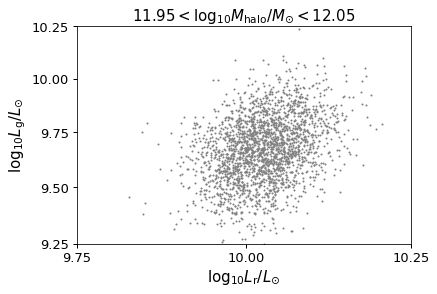

In [9]:
halo_mass_mask = (galaxies['host_halo_mass'] < 10**12.05) & (galaxies['host_halo_mass'] > 10**11.95)

fig, ax = plt.subplots(1, 1)
__=ax.loglog()

nskip2 = 10
__=ax.scatter(np.log10(galaxies['luminosity_rband'][halo_mass_mask][::nskip2]), 
              np.log10(galaxies['luminosity_gband'][halo_mass_mask][::nskip2]), 
              s=1, color='gray')

xlim = ax.set_xlim(9.75, 10.25)
ylim = ax.set_ylim(9.25, 10.25)

xlabel = ax.set_xlabel(r'$\log_{10}L_{\rm r}/L_{\odot}$')
ylabel = ax.set_ylabel(r'$\log_{10}L_{\rm g}/L_{\odot}$')
title = ax.set_title(r'$11.95 < \log_{10}M_{\rm halo}/M_{\odot} < 12.05$')

from matplotlib import ticker
xticks = (9.75, 10, 10.25)
yticks = (9.25, 9.5, 9.75, 10, 10.25)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())

figname = 'rband_gband_correlation_fixed_mass.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')